# Complete analysis for Experiment 2, @Magdeburg

In [1]:
rm(list=ls())

In [3]:
library(dplyr)
library(lme4)
library(ggplot2)
library(BayesFactor)
library(stringr)

### Loading and preprocessing data
Loading raw data and converting integer constants to factors

In [4]:
responses <- read.table(file.path('Experiment 2', 'Experiment 2.csv'), sep=',', dec = '.', header = TRUE)

# converting factors and values to a readable format
responses$DisplayType <- recode(responses$DisplayType, 'H' = 'Horizontally arranged', 'V'= 'Vertically arranged')
responses$RotationAxis <- recode(responses$RotationAxis, 'X'='Horizontal', 'Y'= 'Vertical')
responses$Percept <- factor(responses$Percept, levels= c(-2, -1, 1), labels= c('unclear', 'counter-rotation', 'co-rotation'))
responses$Background <- factor(responses$Background, levels= c(0, 1), labels= c('absent', 'present'))

# computing axes configuration
responses$Axes.Configuration <- 'parallel'
responses$Axes.Configuration[(responses$DisplayType=='Horizontally arranged') & (responses$RotationAxis=='Horizontal')] <- 'co-axial'
responses$Axes.Configuration[(responses$DisplayType=='Vertically arranged') & (responses$RotationAxis=='Vertical')] <- 'co-axial'
responses$Axes.Configuration <- factor(responses$Axes.Configuration)

### Computing duration of individual percepts

In [5]:
block.duration <- 300 # Duration of a single continuous presentaiton run in seconds
responses$Duration <- NA
responses$Curtailed <- FALSE # duration of the last percept is curtailed by the end-of-the block
for(i.row in 1:(nrow(responses)-1)){
    if (responses$Time[i.row+1]<responses$Time[i.row]){
        # block end?
        if ((responses$ObserverID[i.row+1]!=responses$ObserverID[i.row]) ||
            (responses$DisplayType[i.row+1]!=responses$DisplayType[i.row]) ||
            (responses$RotationAxis[i.row+1]!=responses$RotationAxis[i.row]) ||
            (responses$Background[i.row+1]!=responses$Background[i.row]) ||
            (responses$Distance[i.row+1]!=responses$Distance[i.row])){
            # block end!
            responses$Duration[i.row] <- block.duration-responses$Time[i.row]
            responses$Curtailed[i.row] <- TRUE
        }
        
        else{
            stop(sprintf('What the Fish? Row %d', i.row))
        }
    }
    else{
        responses$Duration[i.row] <- responses$Time[i.row+1]-responses$Time[i.row]
    }
}

### Computing average counter-rotation for all combinations of conditions
In this case we look separately at all for combinations for the objects' arrangement (horizontally vs. vertically arranged) and of the objects' rotation axis (horizontal or vertical)

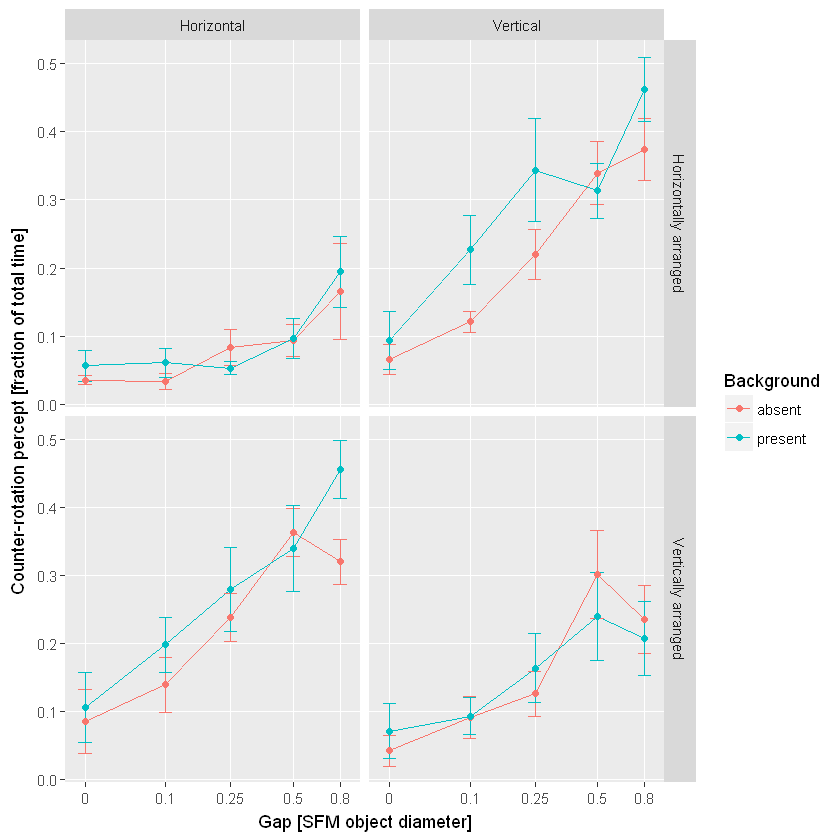

In [24]:
counter.rotation <- responses %>%
    dplyr::filter(Percept=='counter-rotation') %>%
    dplyr::group_by(ObserverID, DisplayType, RotationAxis, Background, Distance) %>%
    dplyr::summarize(total.duration= sum(Duration)/block.duration) %>%
    dplyr::group_by(DisplayType, RotationAxis, Background, Distance) %>%
    dplyr::summarize(
        mean.duration= mean(total.duration, na.rm=TRUE),
        serr.duration= sd(total.duration, na.rm=TRUE)/sqrt(n()))

counter.rotation.plot <- ggplot(data= counter.rotation, 
                          aes(x= Distance+0.1, y= mean.duration, 
                              ymin= mean.duration-serr.duration,
                              ymax= mean.duration+serr.duration,
                              group= Background, color= Background))+
    geom_line()+
    geom_errorbar(width= 0.05)+
#     scale_colour_discrete(guide = FALSE) +
    geom_point() + 
    facet_grid(DisplayType ~ RotationAxis)+
    scale_x_log10(breaks= unique(counter.rotation$Distance)+0.1, 
                  labels= unique(counter.rotation$Distance))+
    theme(panel.grid.minor.x=  element_blank(), panel.grid.minor.y=  element_blank())+
    ylab('Counter-rotation percept [fraction of total time]')+
    xlab('Gap [SFM object diameter]')
print(counter.rotation.plot)
ggsave('Figures/Exp2 - all.pdf', counter.rotation.plot, width= 11, height= 11, units = 'cm', useDingbats = FALSE)

In [25]:
counter.rotation.per.observer <- responses %>%
    dplyr::filter(Percept=='counter-rotation') %>%
    dplyr::group_by(ObserverID, DisplayType, RotationAxis, Background, Distance, Axes.Configuration) %>%
    dplyr::summarize(total.duration= sum(Duration)/block.duration)

# linear-mixed models
lm.null <- lmer(total.duration ~ (1|ObserverID), data= counter.rotation.per.observer, REML=FALSE)
lm.distance <- update(lm.null, .~. + Distance)
lm.layout <- update(lm.distance, .~. + DisplayType)
lm.axis <- update(lm.layout, .~. + RotationAxis)
lm.axes.conf <- update(lm.axis, .~.  + Axes.Configuration)
lm.bg <- update(lm.axes.conf, .~.+Background)
lm.bg.axes.conf <- update(lm.bg, .~. +Background * Axes.Configuration)
lm.summary <- anova(lm.null, lm.distance, lm.layout, lm.axis, lm.axes.conf, lm.bg, lm.bg.axes.conf)
lm.summary
lm.summary$'Pr(>Chisq)'

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
lm.null,3,-254.7706,-243.2661,130.3853,-260.7706,NA,NA,NA
lm.distance,4,-355.1831,-339.8439,181.5916,-363.1831,102.412586,1,4.508283e-24
lm.layout,5,-357.1181,-337.9440,183.5590,-367.1181,3.934962,1,4.729222e-02
lm.axis,6,-360.8410,-337.8321,186.4205,-372.8410,5.722900,1,1.674506e-02
lm.axes.conf,7,-457.1890,-430.3453,235.5945,-471.1890,98.347955,1,3.509631e-23
lm.bg,8,-461.0461,-430.3676,238.5230,-477.0461,5.857111,1,1.551424e-02
lm.bg.axes.conf,9,-463.2582,-428.7449,240.6291,-481.2582,4.212180,1,4.013472e-02


[1]           NA 4.508283e-24 4.729222e-02 1.674506e-02 3.509631e-23
[6] 1.551424e-02 4.013472e-02

## Looking at the probability independent switching given the strength of the perceptual coupling

In [26]:
switch.vs.coupling <- responses %>%
    group_by(ObserverID, DisplayType, RotationAxis, Background, Distance) %>%

    # marking out simultaneous switchs (same dual percept to the same dual percept)
    mutate(iPercept= 1:n(), 
           simultaneous.switch= Percept==lag(Percept)) %>%
    summarise(counter.rotation.prop= sum(Duration[Percept=='counter-rotation'])/sum(Duration),
              balance= abs(counter.rotation.prop-0.5),
              mean.switch.count= sum(is.finite(simultaneous.switch))/2, 
              sim.switch.prop= sum(simultaneous.switch, na.rm= TRUE)/sum(is.finite(simultaneous.switch))) %>%

    # retaining only block with at least 5 switches 
    filter(mean.switch.count>=5)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: sim.switch.prop ~ balance + (1 | ObserverID)
   Data: switch.vs.coupling

REML criterion at convergence: -419.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3915 -0.6691 -0.0208  0.6947  2.3145 

Random effects:
 Groups     Name        Variance Std.Dev.
 ObserverID (Intercept) 0.004884 0.06989 
 Residual               0.016639 0.12899 
Number of obs: 358, groups:  ObserverID, 9

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   0.23826    0.02898  16.10000   8.223 3.78e-07 ***
balance       1.07981    0.04855 353.30000  22.243  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
        (Intr)
balance -0.546

Estimate,Std.Error,df,t.value,p.value,R.sqr
0.2382632,0.02897688,16.05443,8.222527,3.784573e-07,0.8989489
1.0798108,0.04854606,353.30968,22.243018,0.000000e+00,0.7638007


Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 1 rows containing missing values (geom_point)."Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 1 rows containing missing values (geom_point)."

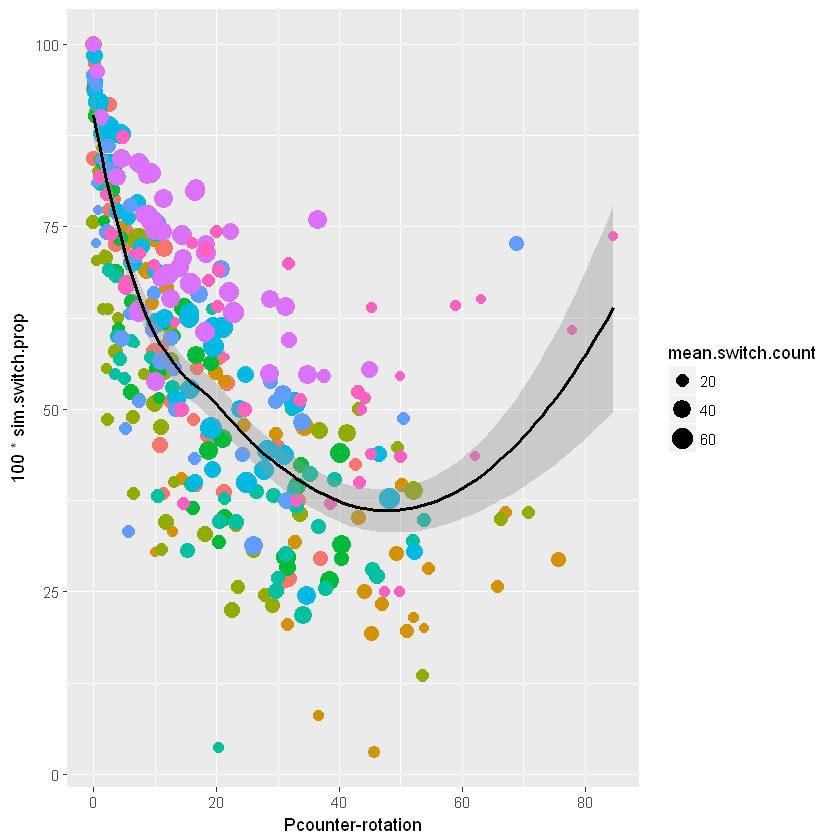

In [28]:
rcontrast<-function(t, df) {
    return (sqrt(t^2/(t^2 + df)))
}

sim.switch.model <- lmerTest::lmer(sim.switch.prop ~ balance + (1|ObserverID), data=  switch.vs.coupling)
summary(sim.switch.model)
coefficients.only <- data.frame(summary(sim.switch.model)$coefficients)
colnames(coefficients.only) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value')
dplyr::mutate(coefficients.only, R.sqr= rcontrast(t.value, df))

coupling.vs.sim.switches.plot <- ggplot(data= switch.vs.coupling, aes(x= 100*counter.rotation.prop, y= 100*sim.switch.prop)) +
    geom_point(aes(color= ObserverID, size= mean.switch.count))+
    geom_smooth(color= 'black', method='loess')+
    scale_colour_discrete(guide = FALSE) +
    xlab('Pcounter-rotation')
print(coupling.vs.sim.switches.plot)
ggsave('Figures/Exp2 - independent switching versus coupling.pdf', coupling.vs.sim.switches.plot, width= 13, height= 7.5, units = 'cm',  useDingbats = FALSE)

In [21]:
balanced.blocks <- switch.vs.coupling %>%
    mutate(balanced= (counter.rotation.prop>0.25) & (counter.rotation.prop<0.75)) %>%
    filter(balanced== TRUE)
cat(sprintf('Number of balanced blocks: %d\n', nrow(balanced.blocks)))
cat(sprintf('Number of balanced participants: %d\n', length(unique(balanced.blocks$ObserverID))))

Number of balanced blocks: 103
Number of balanced participants: 9


In [27]:
persistence.relative.to.chance.level <- function(perceptual.reports){
    reports.N <- length(perceptual.reports)
    actual.persistence <- mean(perceptual.reports[1:(reports.N-1)]==perceptual.reports[2:reports.N])

    shuffle.repetitions <- 1000
    shuffled.persistence <- rep(NA, shuffle.repetitions) 
    for(iteration in 1:shuffle.repetitions){
        shuffled.reports <- sample(perceptual.reports)
        shuffled.persistence[iteration] <- mean(shuffled.reports[1:(reports.N-1)]==shuffled.reports[2:reports.N])
    }    

    # z-scoring the actual persistence based on the randomly sampled sequences
    z.scores <- c(scale(c(actual.persistence, shuffled.persistence)))
    return(z.scores[1])
    
    # computing there the actual persistence is relative to a distribution of randomly shuffled reports
    # we need to use -, as t-test measures distance from the center of distribution to the value and we need it the other way around
#     return(-t.test(logit(shuffled.persistence), mu= logit(actual.persistence))$statistic)
}

perceptual.trapping <- responses %>% 
    semi_join(balanced.blocks) %>%

    # adding unique block index
    group_by(ObserverID, DisplayType, RotationAxis, Background, Distance) %>%
    mutate(block.id= str_c(as.character(ObserverID[1]), as.character(DisplayType[1]), as.character(RotationAxis[1]), as.character(Background[1]), as.character(Distance[1]))) %>%
    ungroup() %>%
    mutate(block.id= as.factor(block.id)) %>%

    # computing probability of perceptual trapping
    group_by(ObserverID, block.id) %>%
    summarise(p.trapped= mean(Percept[1:(n()-1)]==Percept[2:n()]),
              z.trapped= persistence.relative.to.chance.level(Percept)) 

Joining, by = c("ObserverID", "DisplayType", "RotationAxis", "Background", "Distance")



	One Sample t-test

data:  perceptual.trapping$z.trapped
t = -7.9648, df = 102, p-value = 2.435e-12
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -1.929260 -1.159946
sample estimates:
mean of x 
-1.544603 


R^2: 0.62

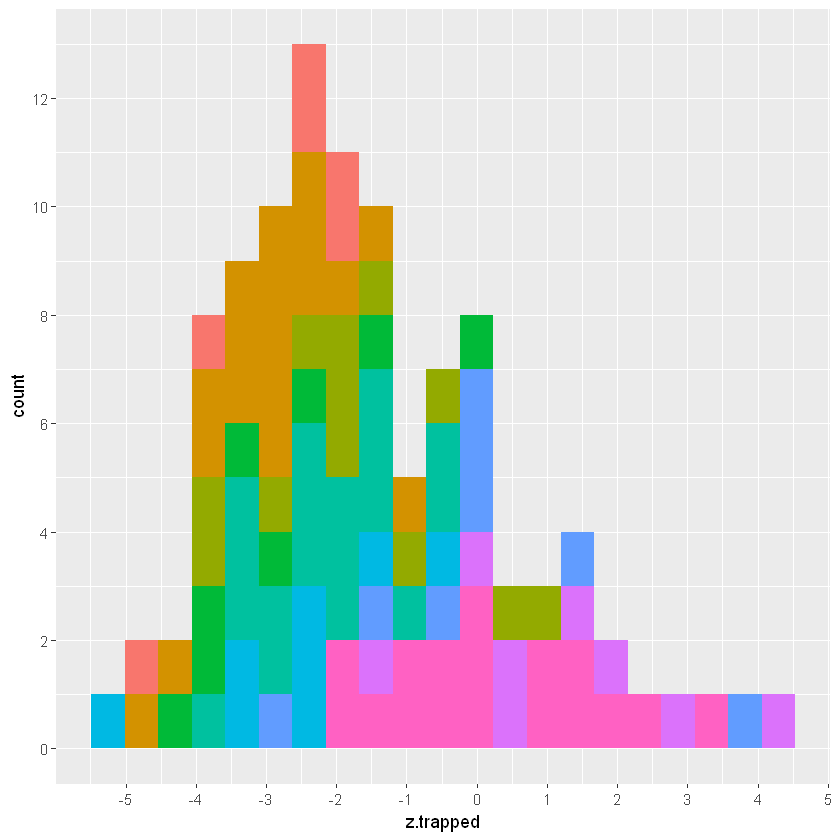

In [23]:
t.trapped <- t.test(perceptual.trapping$z.trapped)
t.trapped
cat(sprintf('R^2: %.2f', rcontrast(t.trapped$statistic, t.trapped$parameter)))

trapping.plot <- ggplot(data= perceptual.trapping, aes(x= z.trapped, fill= ObserverID)) + 
    geom_histogram(bins= 21)+
    scale_y_continuous(breaks= seq(0, 14, 2))+
    scale_x_continuous(breaks= seq(-6, 5, 1))+
    theme(legend.position="none")
print(trapping.plot)
ggsave('Figures/Exp2 - perceptual trapping.pdf', trapping.plot, width= 10.5, height= 5.0, units = 'cm',  useDingbats = FALSE)